
## Taller de Procesamiento de Señales - TP4 Análisis de Discriminante y Vecinos más cercanos
### Alumno: Julián Stejman

--- 


Iris es un género de plantas rizomatosas de la familia Iridaceae. Dentro de las plantas de Iris existen muchas especies distintas, entre ellas *setosa*, *versicolor* y *virgínica*. Se desea desarrollar un clasificador de dichas plantas a partir del tamaño de su sépalo.

In [22]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
iris_data, iris_targets = load_iris(return_X_y=True, as_frame=True)
iris_data = iris_data[['sepal length (cm)', 'sepal width (cm)']]
iris_targets = iris_targets.astype('category')


Se obtiene el dataset de las flores Iris con el motivo de clasificarlas en base a sus dimensiones de sépalos. Aquí se puede ver un scatter de las flores diferenciadas por especie por el color del marcador.

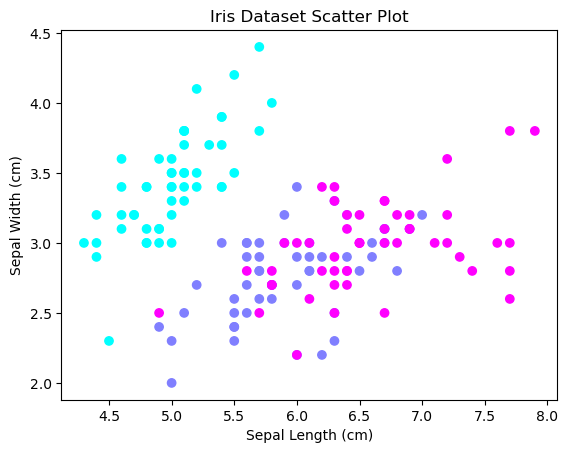

In [23]:

ax, fig = plt.subplots()
fig.scatter(iris_data['sepal length (cm)'], iris_data['sepal width (cm)'], c=iris_targets, cmap="cool")
fig.set_xlabel('Sepal Length (cm)')
fig.set_ylabel('Sepal Width (cm)')
fig.set_title('Iris Dataset Scatter Plot')
plt.show()


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris_data, iris_targets, train_size=0.7)

Se define la clase `DA_classifier` con el motivo de poder manejar clasificadores LDA y QDA. En ambos casos se fittea cargando las probabilidades previas, medias, covarianzas locales y la covarianza compartida. Luego el criterio de elección de máximo es por un discriminante, sea lineal o cuadrático, del cual se le aplica un softmax para dar probabilidades de pertenecer a alguna de las clases. Se predice finalmente eligiendo el argmax de las probabilidades de caer en cada clase. 

In [44]:
import numpy as np
import pandas as pd
class DA_classifier: 
    def __init__(self, order="linear"):
        self.means = None
        self.cov = None
        self.priors = None
        self.classes = None
        self.sigmak = None
        self.order = order
    def fit(self, X, y):
        self.classes = y.unique()
        num_classes = len(self.classes)
        num_samples = X.shape[0]

        # valores de c_k
        self.priors = np.array([np.sum(y == c) / num_samples for c in self.classes]) 
        # medias
        self.means = np.array([np.mean(X[y == c], axis=0) for c in self.classes])
        # valores de sigma_k
        self.sigmak = np.array([1/(num_classes - 1) * (X[y == c] - self.means[c]).T@(X[y == c] - self.means[c]) for c in self.classes])
        # covariancia
        self.cov = 1/(num_samples-num_classes) * np.sum((num_classes -1)*self.sigmak, axis=0)
    def _softmax(self, X):
        exp = np.exp(X)
        return exp / np.sum(exp, axis=0, keepdims=True)
    def _predict_proba_linear(self, X):
        lin_discr = [self.means[c].T @ np.linalg.inv(self.cov) @ X.T 
            - 0.5 * self.means[c].T @ np.linalg.inv(self.cov) @ self.means[c] 
            + np.log(self.priors[c]) for c in range(len(self.classes))]
        probas = self._softmax(np.array(lin_discr))
        return probas.T
    def _predict_proba_quadratic(self, X):
        quad_discr = []
        for c in range(len(self.classes)):
            diff = X - self.means[c]
            term1 = -0.5 * np.sum(diff @ np.linalg.inv(self.sigmak[c]) * diff, axis=1)
            term2 = np.log(self.priors[c]) - 0.5 * np.log(np.linalg.det(self.sigmak[c]))
            quad_discr.append(term1 + term2)
        probas = self._softmax(np.array(quad_discr))
        return probas.T
    def predict_proba(self, X):
        if self.order == "quadratic":
            return self._predict_proba_quadratic(X)
        elif self.order == "linear":
            return self._predict_proba_linear(X)
        else: 
            raise ValueError("Order must be 'linear' or 'quadratic'")

    def predict(self, X):
        probas = self.predict_proba(X)
        if probas.ndim == 1:
            return np.argmax(probas)
        predictions = np.argmax(probas, axis=1)
        return predictions

In [26]:
lda = DA_classifier(order="linear")
lda.fit(X_train, y_train)

Se puede ver como al fittear se halla la media local y covarianza local para cada especie. Dado que se asume el modelo de mezclas gaussianas, la covarianza de la normal multivariada tiene una representación elíptica donde los "radios" principales de la elipse son los autovectores de la covarianza.  

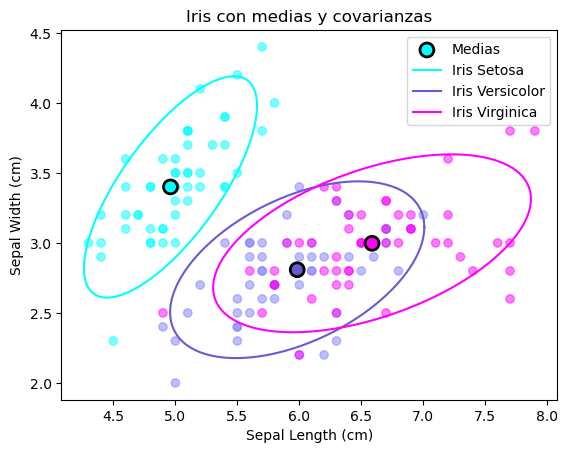

In [27]:
ax, fig= plt.subplots()
fig.scatter(iris_data["sepal length (cm)"], iris_data["sepal width (cm)"], c=iris_targets, cmap="cool", alpha= 0.5)
# medias superpuestas
fig.scatter(lda.means[:, 0], lda.means[:, 1], c=['cyan', 'slateblue', 'magenta'], marker='o', s=100, linewidths=2, edgecolors='black', label="Medias")

# curvas de nivel de covarianzas:
# primero genero puntos de un círculo
u1, u2 = np.cos(np.arange(0, 2*np.pi, 0.01)), np.sin(np.arange(0, 2*np.pi, 0.01))
U = np.matrix([u1,u2])
# luego los transformo con la matriz de covarianza a través de la descomposición de Cholesky y un factor de escala
A0_menos1 = np.linalg.cholesky(lda.sigmak[0])
A1_menos1 = np.linalg.cholesky(lda.sigmak[1])
A2_menos1 = np.linalg.cholesky(lda.sigmak[2])
r = .5
V0 = r * (A0_menos1 @ U).T
V1 = r * (A1_menos1 @ U).T
V2 = r * (A2_menos1 @ U).T
# y los desplazo a la media de cada clase

fig.plot(V0[:, 0] + lda.means[0][0], V0[:, 1] + lda.means[0][1], c='cyan', label='Iris Setosa')
fig.plot(V1[:, 0] + lda.means[1][0], V1[:, 1] + lda.means[1][1], c='slateblue', label='Iris Versicolor')
fig.plot(V2[:, 0] + lda.means[2][0], V2[:, 1] + lda.means[2][1], c='magenta', label='Iris Virginica')
fig.set_xlabel('Sepal Length (cm)')
fig.set_ylabel('Sepal Width (cm)')
fig.set_title('Iris con medias y covarianzas')
fig.legend()
plt.show()

Aquí se puede ver como se generan rectas divisorias entre las clases de la manera que logra separarlas. 

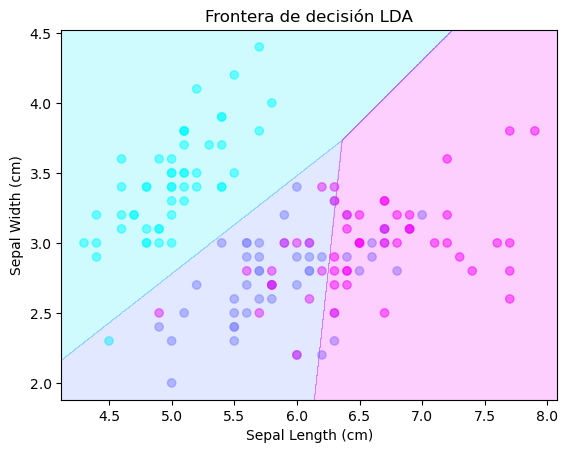

In [28]:
# graficar la frontera de decisión
ax, fig = plt.subplots()
fig.scatter(iris_data['sepal length (cm)'], iris_data['sepal width (cm)'], c=iris_targets, cmap="cool", alpha=0.5)
xlim = fig.get_xlim()
ylim = fig.get_ylim()
# creo un mesh grid con los límites de los ejes
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 1000), np.linspace(ylim[0], ylim[1], 1000))
# genero una predicción
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
# y la reestructuro para graficar
Z = Z.reshape(xx.shape)
fig.contourf(xx, yy, Z, alpha=0.2, cmap="cool")
fig.set_xlabel('Sepal Length (cm)')
fig.set_ylabel('Sepal Width (cm)')
fig.set_title('Frontera de decisión LDA')
plt.show()


Se halla una precisión del 82% para el LDA.

In [29]:
# calcular accuracy
from sklearn.metrics import accuracy_score
y_pred = lda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.82


Se generan labels luego de elegir con las probabilidades previas $c_k$ una cantidad de muestras de cada clase. Luego se generan muestras de cada clase a través de `multivariate_normal` con las medias y covarianza compartida que halló el modelo. 

In [30]:
# generar muestras en base al modelo
n_samples = 30
generated_samples = []

# genero etiquetas aleatorias
generated_labels = np.random.choice(lda.classes, size=n_samples, p=lda.priors)
for i in generated_labels:
    # genero muestras aleatorias
    samples = np.random.multivariate_normal(lda.means[i], lda.cov)
    generated_samples.append(samples)
generated_samples = np.array(generated_samples)
generated_labels = np.array(generated_labels)


Se puede ver como las muestras encajan bastante bien con las fronteras de decisión que halló previamente.

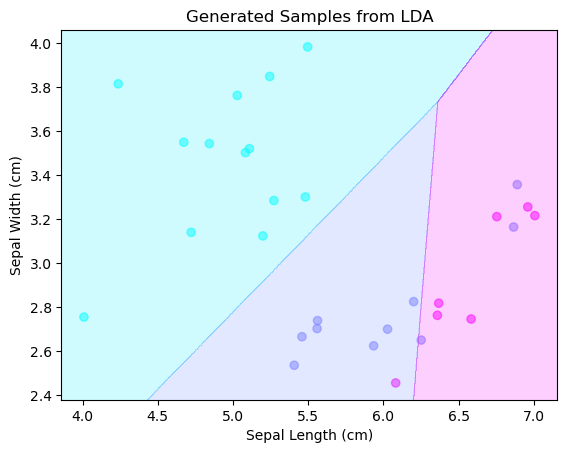

In [31]:
ax, fig = plt.subplots()
fig.scatter(generated_samples[:, 0], generated_samples[:, 1], c=generated_labels, cmap="cool", alpha=0.5)
fig.set_xlabel('Sepal Length (cm)')
fig.set_ylabel('Sepal Width (cm)')
fig.set_title('Generated Samples from LDA')
xlim = fig.get_xlim()
ylim = fig.get_ylim()
# creo un mesh grid con los límites de los ejes
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 1000), np.linspace(ylim[0], ylim[1], 1000))
# genero una predicción
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
# y la reestructuro para graficar
Z = Z.reshape(xx.shape)
fig.contourf(xx, yy, Z, alpha=0.2, cmap="cool")

Ahora se repite el procedimiento previo pero con un modelo QDA. 

In [51]:
qda = DA_classifier(order="quadratic")
qda.fit(X_train, y_train)

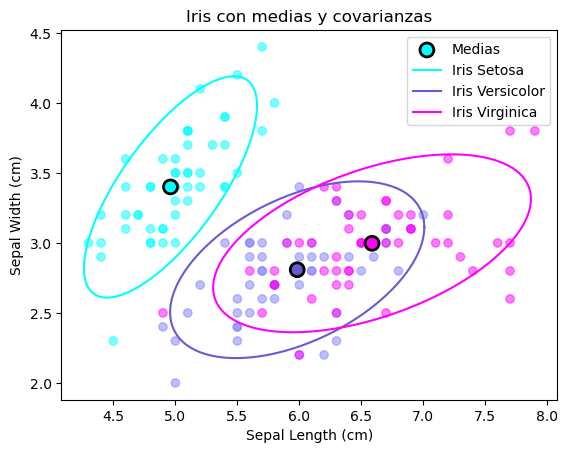

In [53]:
ax, fig = plt.subplots()
fig.scatter(iris_data['sepal length (cm)'], iris_data['sepal width (cm)'], c=iris_targets, cmap="cool", alpha=0.5)
# medias superpuestas
fig.scatter(qda.means[:, 0], qda.means[:, 1], c=['cyan', 'slateblue', 'magenta'], marker='o', s=100, linewidths=2, edgecolors='black', label="Medias")
# curvas de nivel de covarianzas:
# primero genero puntos de un círculo
u1, u2 = np.cos(np.arange(0, 2*np.pi, 0.01)), np.sin(np.arange(0, 2*np.pi, 0.01))
U = np.matrix([u1,u2])
# luego los transformo con la matriz de covarianza a través de la descomposición de Cholesky y un factor de escala
A0_menos1 = np.linalg.cholesky(qda.sigmak[0])
A1_menos1 = np.linalg.cholesky(qda.sigmak[1])
A2_menos1 = np.linalg.cholesky(qda.sigmak[2])
r = .5
V0 = r * (A0_menos1 @ U).T
V1 = r * (A1_menos1 @ U).T
V2 = r * (A2_menos1 @ U).T
# y los desplazo a la media de cada clase
fig.plot(V0[:, 0] + qda.means[0][0], V0[:, 1] + qda.means[0][1], c='cyan', label='Iris Setosa')
fig.plot(V1[:, 0] + qda.means[1][0], V1[:, 1] + qda.means[1][1], c='slateblue', label='Iris Versicolor')
fig.plot(V2[:, 0] + qda.means[2][0], V2[:, 1] + qda.means[2][1], c='magenta', label='Iris Virginica')
fig.set_xlabel('Sepal Length (cm)')
fig.set_ylabel('Sepal Width (cm)')
fig.set_title('Iris con medias y covarianzas')
fig.legend()
plt.show()


Inmediatamente, se nota que las fronteras de decisión en este caso son curvas y no rectas. No obstante, no por utilizar un modelo más complejo se obtiene un mejor resultado, de hecho se obtiene un mucho inferior.

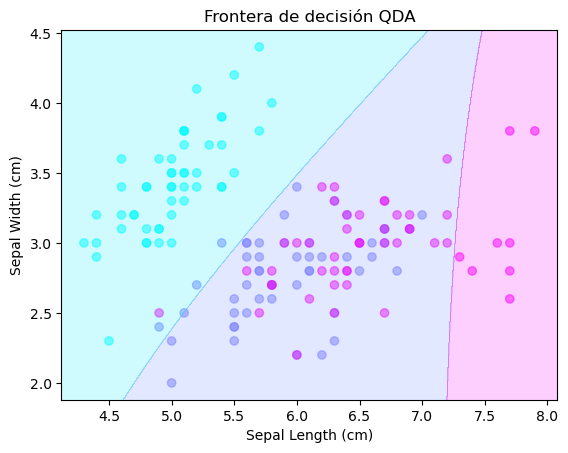

In [52]:
ax, fig = plt.subplots()
fig.scatter(iris_data['sepal length (cm)'], iris_data['sepal width (cm)'], c=iris_targets, cmap="cool", alpha=0.5)
# graficar la frontera de decisión
xlim = fig.get_xlim()
ylim = fig.get_ylim()
# creo un mesh grid con los límites de los ejes
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 1000), np.linspace(ylim[0], ylim[1], 1000))
# genero una predicción
Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
# y la reestructuro para graficar
Z = Z.reshape(xx.shape)
fig.contourf(xx, yy, Z, alpha=0.2, cmap="cool")
fig.set_xlabel('Sepal Length (cm)')
fig.set_ylabel('Sepal Width (cm)')
fig.set_title('Frontera de decisión QDA')
plt.show()

Se puede ver que este modelo tiene una precisión bastante inferior rondando el 38%, o sea, menor que la mitad que el modelo anterior.

In [50]:
predictions = qda.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.38


Dado que el proceso de fittear y generar muestras es igual que en el clasificador lineal, la diferencia está en las muestras mal clasificadas por sus fronteras de decisión. 

In [54]:
# generar muestras en base al modelo
n_samples = 30
generated_samples_qda = []

# genero etiquetas aleatorias
generated_labels_qda = np.random.choice(qda.classes, size=n_samples, p=qda.priors)
for i in generated_labels_qda:
    # genero muestras aleatorias
    samples = np.random.multivariate_normal(qda.means[i], qda.cov)
    generated_samples_qda.append(samples)
generated_samples_qda = np.array(generated_samples_qda)
generated_labels_qda = np.array(generated_labels_qda)


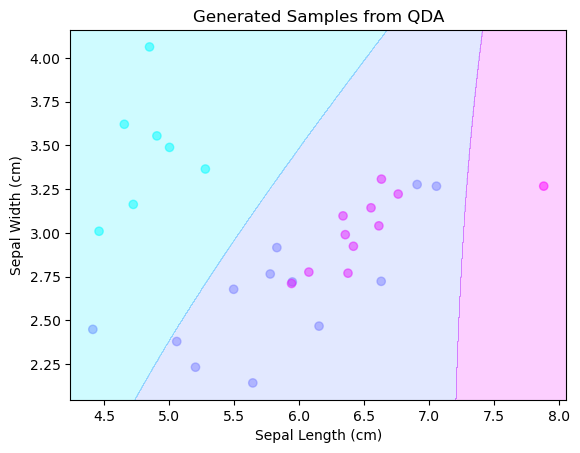

In [55]:
ax, fig = plt.subplots()
fig.scatter(generated_samples_qda[:, 0], generated_samples_qda[:, 1], c=generated_labels_qda, cmap="cool", alpha=0.5)
fig.set_xlabel('Sepal Length (cm)')
fig.set_ylabel('Sepal Width (cm)')
fig.set_title('Generated Samples from QDA')
xlim = fig.get_xlim()
ylim = fig.get_ylim()
# creo un mesh grid con los límites de los ejes
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 1000), np.linspace(ylim[0], ylim[1], 1000))
# genero una predicción
Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
# y la reestructuro para graficar
Z = Z.reshape(xx.shape)
fig.contourf(xx, yy, Z, alpha=0.2, cmap="cool")

Ahora se propone hacer el procedimiento anterior pero con un clasificador de KNN, con K = 6. Para entrenar, solamente se le proveen los datos y las etiquetas. Para predecir probabilidades se pide la distancia euclídea con todos los datos obtenidos al fittear, se busca las muestras más cercanas y se halla la probabilidad de que cayera en alguna de estas clases. Nuevamente, el criterio de decisión es la clase con la máxima probabilidad.

In [104]:
from collections import Counter
from sklearn.metrics.pairwise import euclidean_distances

class KNN_classifier:
    def __init__(self, k=6):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict_proba(self, X):
        probabilities = []
        # guardo las distancias euclidianas entre los puntos a predecir y los de train
        distances = euclidean_distances(X, self.X_train)
        for i, point_distances in enumerate(distances):
            # obtengo los índices de los k vecinos más cercanos
            nearest_indices = np.argsort(point_distances)[:self.k]
            # cuento las clases de los k vecinos más cercanos
            nearest_classes = self.y_train.iloc[nearest_indices]
            # cuento la cantidad de veces que aparece cada clase
            class_counts = Counter(nearest_classes)
            # calculo la probabilidad de cada clase
            prob_arr = [class_counts.get(cls, 0) / self.k for cls in self.y_train.cat.categories]
            probabilities.append(prob_arr)
        return np.array(probabilities)
    
    def predict(self, X):
        probabilities = self.predict_proba(X)
        return np.argmax(probabilities, axis=1)


Se puede ver que las fronteras de decisión aquí son bastante más complejas que los anteriores casos. Tiene la particularidad de separar a las clases en bloques disjuntos y con formas extrañas. El tiempo de cómputo para hallarlas es bastante mayor. Esto es porque el algoritmo no modela los datos como de alguna distribución probabilística y simplemente halla a través de las coordenadas vecinas cuál es la probabilidad de pertenecer a alguna clase. 

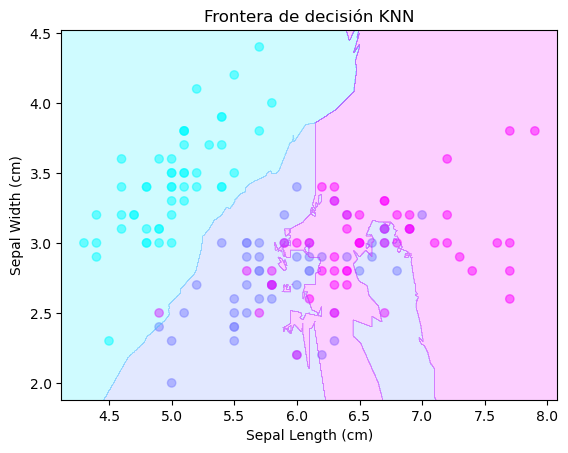

In [103]:
knn = KNN_classifier(k=6)
# Reset the indices of y_train to match X_train
y_train = y_train.reset_index(drop=True)
knn.fit(X_train, y_train)
ax, fig = plt.subplots()
fig.scatter(iris_data['sepal length (cm)'], iris_data['sepal width (cm)'], c=iris_targets, cmap="cool", alpha=0.5)
# graficar la frontera de decisión
xlim = fig.get_xlim()
ylim = fig.get_ylim()
# creo un mesh grid con los límites de los ejes
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 1000), np.linspace(ylim[0], ylim[1], 1000))
# genero una predicción
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
# y la reestructuro para graficar
Z = Z.reshape(xx.shape)
fig.contourf(xx, yy, Z, alpha=0.2, cmap="cool")
fig.set_xlabel('Sepal Length (cm)')
fig.set_ylabel('Sepal Width (cm)')
fig.set_title('Frontera de decisión KNN')
plt.show()


Sin embargo, a diferencia del modelo QDA, este modelo sí gana cierta precisión por su complejidad pero es igual a la precisión que obtuvo el modelo LDA. 

In [107]:
knn = KNN_classifier(k=6)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
accuracy = accuracy_score(y_test, knn_predictions)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.82
